In [1]:
import os

os.environ["CUDA_DEVICE_ORDER"]="PCI_BUS_ID"
os.environ["CUDA_VISIBLE_DEVICES"]="6,7"

os.environ['CUDA_PATH']='/usr/local/cuda-11'

In [2]:
import pandas as pd
import numpy as np
from datasets import load_dataset, Dataset
import re

In [3]:
prds = pd.read_json('results_only_calls.json', lines=True)

In [4]:
trnds = pd.read_json('/mnt/data/mart/gorilla/data/apibench/huggingface_train.json', lines=True)

In [7]:
prds_knn = pd.read_json('results_knn.json')

In [119]:
prds_original_optimistic = pd.read_json('results_original.json', lines=True)
prds_original_optimistic.generated_call = prds_original_optimistic.generated_call.apply(lambda x: re.findall(r"model\s{0,2}=\s{0,2}([a-zA-Z0-9\._]*?\(.?'.+?'.*?\))", x)[0] if len(re.findall(r"model\s{0,2}=\s{0,2}([a-zA-Z0-9\._]*?\(.?'.+?'.*?\))", x))>0 else '')

In [114]:
prds_original_pessimistic = pd.read_json('results_original.json', lines=True)
prds_original_pessimistic.generated_call = prds_original_pessimistic.generated_call.apply(lambda x: 'Fake.call('+re.findall(r"model.*?('[^\s]+?')", x)[0] + ')' if len(re.findall(r"model.*?('[^\s]+?')", x))>0 else '')

In [10]:
prds_desc = pd.read_json('results_with_description.json', lines=True)
prds_desc.generated_call = prds_desc.generated_call.apply(lambda x: re.findall(r'<<<api_call>>>:(.+)\n', x)[0])

In [63]:
df_instructions_list = trnds.code.apply(lambda x: re.findall(r'###.?Instruction: (.+)', x)[0])

In [65]:
trnds = trnds[df_instructions_list.apply(len) > 0]

In [68]:
trnds['request'] = df_instructions_list[df_instructions_list.apply(len) > 0]

In [5]:
from sklearn.neighbors import KNeighborsClassifier
from tqdm.auto import tqdm

In [79]:
unique_calls = trnds.api_call.unique()

In [89]:
X, y = [], []

for i, row in tqdm(trnds.iterrows(), total=len(trnds)):
    y.append(np.where(unique_calls == row.api_call)[0][0])
    X.append(w['transformer.word_embeddings.weight'][tokenizer.encode(row.request)].mean(0).detach().cpu().numpy())

  0%|          | 0/8188 [00:00<?, ?it/s]

In [91]:
X = np.stack(X)

In [93]:
%%time
knncls = KNeighborsClassifier()
knncls.fit(X, y)

CPU times: user 24.4 ms, sys: 0 ns, total: 24.4 ms
Wall time: 23.4 ms


KNeighborsClassifier()

In [104]:
prds_knn = []

for i, row in tqdm(prds.iterrows(), total=len(prds)):
    try:
        cur_predict = {'request': row.request, 
                       'expected_call': row.expected_call, 
                       'generated_call': unique_calls[knncls.predict(w['transformer.word_embeddings.weight'][tokenizer.encode(row.request)].mean(0, keepdims=True))][0]}
        prds_knn.append(cur_predict)
    except:
        pass

  0%|          | 0/911 [00:00<?, ?it/s]

In [107]:
prds_knn = pd.DataFrame(prds_knn)

In [109]:
prds_knn.to_json('results_knn.json')

In [193]:
pos = -1

print('validation request: ', prds.iloc[pos].request)
print('validation call: ', prds.iloc[pos].expected_call)

print(f'training requests ({(trnds.api_call == prds.iloc[pos].expected_call).sum()} Stk.) for the same call:')
for i, row in trnds[trnds.api_call == prds.iloc[pos].expected_call].iterrows():
    print(f'\t -{row.request}')

validation request:  Can you figure a way to predict electricity consumption? We need to better allocate resources.
validation call:  RandomForestRegressor(max_depth=10, n_estimators=50, random_state=59)
training requests (8 Stk.) for the same call:
	 -Our company is managing a solar farm and we want to predict the electricity consumption for the next week. 
	 -We have an electrical consumption dataset and we need to predict the consumption of electricity within the next month.
	 -Help me predict the future electricity consumption for the next three days based on the historical data.
	 -Find a way to predict the electricity consumption by using the historical data of electricity demand.
	 -A local electricity company is looking to build a machine learning model to predict electricity consumption in their city for the next quarter. They need assistance in selecting and building the right model to predict the consumption accurately.
	 -My company wants to predict electricity consumption 

In [192]:
pos = 909

print('validation request: ', prds.iloc[pos].request)
print('validation call: ', prds.iloc[pos].expected_call)

print(f'training requests ({(trnds.api_call == prds.iloc[pos].expected_call).sum()} Stk.) for the same call:')
for i, row in trnds[trnds.api_call == prds.iloc[pos].expected_call].iterrows():
    print(f'\t -{row.request}')

validation request:  I work at GreenTech, a startup that provides eco-friendly solutions, and need to determine if a given set of input data will result in high carbon emissions or not.
validation call:  joblib.load('model.joblib')
training requests (262 Stk.) for the same call:
	 -A movie recommendation system needs to categorize movies by genres based on new movies' data like title, director, runtime, and box office numbers.
	 -We are building a flower delivery service website, and we want to show suggestions to users about what kind of iris flower they might like based on some given features.
	 -Create a classifier to predict whether a person earns more than 50k or not, using their age, occupation, and hours worked per week.
	 -We are working with an environmental agency on a project to predict carbon emissions based on input data.
	 -A business is considering making environmentally friendly investments. Please analyze the carbon emissions data of potential investment companies in a

In [117]:
def is_same_function(str_1, str_2):
    f1 = re.findall(r'^(.*)\(', str_1)
    f2 = re.findall(r'^(.*)\(', str_2)
    
    if len(f1)>0 and len(f2)>0:
        return f1[0] == f2[0]
    else:
        return np.nan

def is_same_model(str_1, str_2):
    m1 = re.findall(r'\((.*?)\)', str_1)
    m2 = re.findall(r'\((.*?)\)', str_2)
    
    if len(m1) > 0 and len(m2) > 0:
        return m1[0].split(',')[0] == m2[0].split(',')[0]
    else:
        return np.nan

apis_list = pd.read_json('/mnt/data/mart/gorilla/data/api/huggingface_api.jsonl', lines=True)
    
def is_same_functionality(str_1, str_2):
    m1 = re.findall(r'\((.*?)\)', str_1)
    m2 = re.findall(r'\((.*?)\)', str_2)
    
    if len(m1) > 0 and len(m2) > 0:
        m1 = m1[0].split(',')[0] 
        m2 = m2[0].split(',')[0]
    else:
        return np.nan
    
    f1 = apis_list[apis_list.api_name == m1[1:-1]].functionality
    f2 = apis_list[apis_list.api_name == m2[1:-1]].functionality
    
    if (len(f1) > 0) and (len(f2) > 0):
        return f1.iloc[0] == f2.iloc[0]
    else:
        return np.nan
    
def calc_metrics(prds_df):
    exact_match = [r.expected_call.strip() == r.generated_call.strip() for i,r in prds_df.iterrows()]
    function_match = [is_same_function(r.expected_call.strip(), r.generated_call.strip()) for i,r in prds_df.iterrows()]
    model_match = [is_same_model(r.expected_call.strip(), r.generated_call.strip()) for i,r in prds_df.iterrows()]
    functionality_match = [is_same_functionality(r.expected_call.strip(), r.generated_call.strip()) for i,r in prds_df.iterrows()]
    print(f'type \t\t mean \t nanmean')
    print(f'exact \t\t {np.mean(exact_match):.2f} \t {np.mean(exact_match):.2f}')
    print(f'model \t\t {np.mean(np.array(model_match)==True):.2f} \t {np.nanmean(model_match):.2f}')
    print(f'function \t {np.mean(np.array(function_match)==True):.2f} \t {np.nanmean(function_match):.2f}')
    print(f'functionality \t {np.mean(np.array(functionality_match)==True):.2f} \t {np.nanmean(functionality_match):.2f}')

In [120]:
print('BoW')
calc_metrics(prds_knn)

print('\ncalls only prediction')
calc_metrics(prds)

print('\nfull description prediction')
calc_metrics(prds_desc)

print('\noriginal prediction from code')
calc_metrics(prds_original_optimistic)

print('\nfull prediction from text')
calc_metrics(prds_original_pessimistic)

BoW
type 		 mean 	 nanmean
exact 		 0.14 	 0.14
model 		 0.15 	 0.15
function 	 0.28 	 0.28
functionality 	 0.12 	 0.38

calls only prediction
type 		 mean 	 nanmean
exact 		 0.16 	 0.16
model 		 0.21 	 0.27
function 	 0.33 	 0.42
functionality 	 0.13 	 0.59

full description prediction
type 		 mean 	 nanmean
exact 		 0.18 	 0.18
model 		 0.26 	 0.26
function 	 0.41 	 0.42
functionality 	 0.17 	 0.51

original prediction from code
type 		 mean 	 nanmean
exact 		 0.01 	 0.01
model 		 0.02 	 0.06
function 	 0.05 	 0.16
functionality 	 0.02 	 0.32

full prediction from text
type 		 mean 	 nanmean
exact 		 0.00 	 0.00
model 		 0.03 	 0.03
function 	 0.00 	 0.00
functionality 	 0.04 	 0.34


In [7]:
from transformers import AutoModelForCausalLM

model = AutoModelForCausalLM.from_pretrained("gorilla-llm/gorilla-falcon-7b-hf-v0", trust_remote_code=True)

Loading checkpoint shards:   0%|          | 0/2 [00:00<?, ?it/s]

In [8]:
from transformers import AutoTokenizer, AutoModelForCausalLM
import transformers
import torch

In [9]:
tokenizer = AutoTokenizer.from_pretrained("tiiuae/falcon-7b")
tokenizer.add_special_tokens({'pad_token': '<?>'})

0

In [39]:
!ls /mnt/data/mart/

anaconda3		gorilla		       only_call_stop
anaconda4		llama_weights_hf       test_trainer
falcon-7b-sharded-bf16	llama_weights_initial  with_description
first_gorilla		only_call


In [40]:
w = torch.load('/mnt/data/mart/only_call_stop/pytorch_model-00001-of-00003.bin')

In [43]:
w['transformer.word_embeddings.weight'].shape

torch.Size([65024, 4544])

In [10]:
from accelerate import init_empty_weights, infer_auto_device_map, load_checkpoint_and_dispatch
from transformers import AutoConfig, AutoModelForCausalLM

In [1]:
from tune_gorilla import prep_model

In [2]:
# model = prep_model("/mnt/data/mart/test_trainer/checkpoint-625/")
# model = prep_model("/mnt/data/mart/falcon-7b-sharded-bf16/")
# model = prep_model("/mnt/data/mart/test_rewired_checkpoint/")
# model = prep_model("/mnt/data/mart/with_description/")
# model = prep_model("/mnt/data/mart/only_call_stop/")
model = prep_model("/mnt/data/mart/gorilla-falcon-7b-hf-v0")

OutOfMemoryError: CUDA out of memory. Tried to allocate 316.00 MiB (GPU 6; 23.65 GiB total capacity; 2.78 GiB already allocated; 301.62 MiB free; 2.79 GiB reserved in total by PyTorch) If reserved memory is >> allocated memory try setting max_split_size_mb to avoid fragmentation.  See documentation for Memory Management and PYTORCH_CUDA_ALLOC_CONF

In [12]:
model = model.eval()

In [13]:
pipeline = transformers.pipeline(
    "text-generation",
    model=model,
    tokenizer=tokenizer,
    torch_dtype=torch.bfloat16,
    trust_remote_code=True,
    device_map="auto",
    device='cuda:1'
)

Both `device` and `device_map` are specified. `device` will override `device_map`. You will most likely encounter unexpected behavior. Please remove `device` and keep `device_map`.


OutOfMemoryError: CUDA out of memory. Tried to allocate 316.00 MiB (GPU 1; 23.65 GiB total capacity; 22.91 GiB already allocated; 235.19 MiB free; 22.97 GiB reserved in total by PyTorch) If reserved memory is >> allocated memory try setting max_split_size_mb to avoid fragmentation.  See documentation for Memory Management and PYTORCH_CUDA_ALLOC_CONF

In [15]:
req = prds.request[0]
prompt = f"###Instruction: {req}\n###Output: "
sequences = pipeline(prompt, max_length=256, do_sample=True, top_k=10, num_return_sequences=1, eos_token_id=tokenizer.eos_token_id)
cur_gen['generated_call'] = sequences[0]['generated_text'][len(prompt):]

/mnt/data/mart/anaconda4/lib/python3.10/site-packages/transformers/generation/utils.py:1259: UserWarning: You have modified the pretrained model configuration to control generation. This is a deprecated strategy to control generation and will be removed soon, in a future version. Please use a generation configuration file (see https://huggingface.co/docs/transformers/main_classes/text_generation)
  warnings.warn(
Setting `pad_token_id` to `eos_token_id`:11 for open-end generation.


KeyboardInterrupt: 

In [10]:
from tqdm.auto import tqdm

In [23]:
eval_hf = pd.read_json('/mnt/data/mart/gorilla/data/apibench/huggingface_eval.json', lines=True)

In [12]:
prds

,request,expected_call,generated_call
0,Design a feature for a social media website to...,AutoModel.from_pretrained('princeton-nlp/unsup...,SentenceTransformer('sentence-transformers/di...
1,The user is interested in a tool to find relat...,AutoModel.from_pretrained('GanjinZero/UMLSBert...,AutoModel.from_pretrained('cambridgeltl/SapBE...
2,"As a journalist, I am curious about speech sen...",HubertModel.from_pretrained('facebook/hubert-l...,Wav2Vec2Processor.from_pretrained('hackathon-...
3,A chat service needs a way to compare and clus...,AutoModel.from_pretrained('rasa/LaBSE'),AutoModel.from_pretrained('rasa/LaBSE')
4,I am an interior designer and want to showcase...,StableDiffusionInpaintPipeline.from_pretrained...,"pipeline('text-to-image', model='22h/vintedoi..."
...,...,...,...
906,Can you classify the audio clip to determine w...,"pipeline('voice-activity-detection', model='Ek...","pipeline('audio-classification', model='mazko..."
907,I need to predict digit categories based on so...,load('path_to_folder/sklearn_model.joblib'),load('path_to_folder/sklearn_model.joblib')
908,"In surveillance operations, transcripts are us...",Pipeline.from_pretrained('pyannote/speaker-dia...,/run.sh --skip_data_prep false --skip_train tr...
909,"I work at GreenTech, a startup that provides e...",joblib.load('model.joblib'),joblib.load('model.joblib')


In [13]:
trnds.iloc[0].code

"###Instruction: Write an API implementation that takes customer reviews as input and extracts features to analyze customer sentiment.\n###Output: <<<domain>>>: Natural Language Processing Feature Extraction\n<<<api_call>>>: AutoModel.from_pretrained('YituTech/conv-bert-base')\n<<<api_provider>>>: Hugging Face Transformers\n<<<explanation>>>: 1. We import the necessary classes from the transformers package. This includes AutoTokenizer and AutoModel for tokenizing and processing customer review text.\n2. We use the from_pretrained method of the AutoModel class to load the pre-trained model 'YituTech/conv-bert-base'. This model is based on ConvBERT and is suitable for feature extraction in text data.\n3. We load the customer review text, tokenize it, and use the model to extract features from the review. These features can then be used to analyze customer sentiment.\n<<<code>>>: from transformers import AutoTokenizer, AutoModel\ntokenizer = AutoTokenizer.from_pretrained('YituTech/conv-be

In [50]:
for gen in generations:
    print(is_same_function(gen['expected_call'], gen['generated_call']))

False
True
True
True
False
False


In [53]:
for gen in generations:
    print(is_same_model(gen['expected_call'], gen['generated_call']))

False
False
True
True
False
False


In [109]:
for gen in generations:
    print(is_same_functionality(gen['expected_call'], gen['generated_call']))

Feature Extraction Sentence Embeddings
False
Feature Extraction Fill-Mask
False
0
Feature Extraction Feature Extraction
True
Image generation and modification based on text prompts Text-to-Image
False
0


In [39]:
from matplotlib import pyplot as plt
%matplotlib inline

(array([  1.,   5.,  62., 206., 277., 186., 107.,  41.,  20.,   6.]),
 array([  0. ,  26.3,  52.6,  78.9, 105.2, 131.5, 157.8, 184.1, 210.4,
        236.7, 263. ]),
 <BarContainer object of 10 artists>)

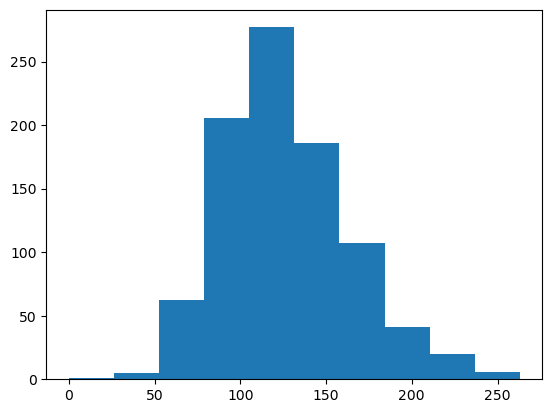

In [40]:
plt.hist([len(i) for i in generated_calls])

In [30]:
full_text

'###Instruction: Our team works on a drug development project. We need to process large amounts of biomedical text to identify entities, relations and answer questions that might be helpful.'

In [13]:
generated_calls

[["SentenceTransformer('sentence-transformers/multi-qa-MiniLM-L6-cos-v1')"],
 ["AutoModel.from_pretrained('GanjinZero/UMLSBert_ENG')"],
 ["pipeline('audio-classification', model='superb/hubert-large-superb-er')"],
 ["AutoModel.from_pretrained('rasa/LaBSE')"],
 ["StableDiffusionPipeline.from_pretrained('dreamlike-art/dreamlike-photoreal-2.0', torch_dtype=torch.float16)"],
 ["Blip2ForConditionalGeneration.from_pretrained('Salesforce/blip2-flan-t5-xxl')"],
 ["AutoModelForCausalLM.from_pretrained('microsoft/git-large-textcaps')"],
 ["pipeline('object-detection', model='microsoft/chart-qa-base')"],
 ["pipeline('text-to-video', model='camenduru/text2-video-zero')"],
 ["TimesformerForVideoClassification.from_pretrained('facebook/timesformer-hr-finetuned-k600')"],
 ["DiffusionPipeline.from_pretrained('damo-vilab/text-to-video-ms-1.7b-legacy', torch_dtype=torch.float16, variant=fp16)"],
 ["pipeline('image-to-text', model='microsoft/git-base')"],
 ["pipeline('visual-question-answering', model='m